# Create Data Vector: From Cosmosis Datablock
# Validate Hankl Transformations

Author: Johnny Esteves <br>
Created: May 2nd

In [1]:
#!/usr/bin/env python
import os

import sys
import numpy as np
import matplotlib.pyplot as plt
from astropy.io.fits import getdata
from astropy.table import Table
from scipy.interpolate import interp1d

In [2]:
# !pip3 install fitsio

In [3]:
import matplotlib
matplotlib.rc('xtick', labelsize=20, top=True, direction='in')
matplotlib.rc('ytick', labelsize=20, right=True, direction='in')
matplotlib.rc('axes', linewidth=1, labelsize=20)
matplotlib.rc('xtick.major', size=5)
#matplotlib.rc('xtick.minor', size=5)
matplotlib.rc('ytick.major', size=5)
#matplotlib.rc('ytick.minor', size=5)

In [4]:
from astropy.cosmology import FlatLambdaCDM
cosmo0 = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
const = 1.67e-7 * (0.3 * 0.7**2) # /Mpc^2
rhom = const/6.01e-19  # Msun/Mpc^2

cosmo0 

FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=2.725 K, Neff=3.04, m_nu=[0. 0. 0.] eV, Ob0=None)

In [5]:
kw = {'dS':r'$\Delta \Sigma \, \, [M_{\odot}]$',
      'gamma': r'$\left< \gamma_t(\theta) \right>$',
      'Wp':r'$W_p$'}


In [6]:
def get_block(model,col,dtype=None):
    return np.genfromtxt(root+'%s/%s.txt'%(model.lower(), col),dtype=dtype)

root = '/global/common/software/des/jesteves/y3_cluster_cpp/y3_buzzard/datablock_0/'
print(root)

/global/common/software/des/jesteves/y3_cluster_cpp/y3_buzzard/datablock_0/


In [7]:
!ls /global/common/software/des/jesteves/y3_cluster_cpp/y3_buzzard/datablock_0/

avgwp		      correlationfunction      likelihoods	 priors
cdm_baryon_power_lin  cosmological_parameters  mass_function	 recfast
cdm_baryon_power_nl   distances		       matter_power_lin  shear
cluster_abundance     growth_parameters        matter_power_nl	 sigmacritinv
cmb_cl		      kappa		       numbercounts	 wp


In [8]:
!ls /global/common/software/des/jesteves/y3_cluster_cpp/y3_buzzard/datablock_0/mass_function/

dndlnmh.txt  dndlnrh.txt  m_h.txt  r_h.txt  values.txt	z.txt


## Linear Power Spectrum

In [29]:
k_h = get_block("matter_power_lin", "k_h")
P_k = get_block("matter_power_lin", "p_k")
z = get_block("matter_power_lin", "z")

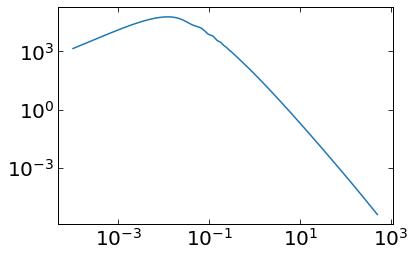

In [10]:
plt.loglog()
plt.plot(k_h, P_k[0])

## NFW Model: Fourrier Space


In [362]:
from scipy.special import sici
def pk_nfw_profile(k_h, m200, rho_c=1., omega_m=0.3, z_eff=0.4):
    c = duffy_concentration_relation(m200, z_eff=z_eff)
    rho_cz = rho_c*(omega_m*(1+z_eff)**3+(1-omega_m))
    r_virial = convert_m200_to_r200(m200, rho_cz)
    rho_k = (m200/(rho_c*omega_m))*normalized_halo_profile(k_h, r_virial, c)
    return rho_k

def duffy_concentration_relation(m_h, z_eff=0.4):
    a_eff = 1/(1+z_eff)
    m_h_pivot = 2e12
    return 7.85*np.power(m_h/m_h_pivot,-0.081)*np.power(a_eff,0.71)

def convert_m200_to_r200(m200,rho,odelta=200):
    rv = np.power(m200*3.0/(4.0*np.pi*rho*odelta),1.0/3.0)
    return rv

def normalized_halo_profile(k_h, r_virial, c):
    """Compute the normalized halo profile function in Fourier space; :math:`u(k|m)`

    For details of the available profile parametrizations, see the class description.

    Note that the function returns unity for :math:`k \\leq 0`.

    Args:
        k_h (np.ndarray): Wavenumber in h/Mpc units.
        r_virial (np.ndarray): Virial radius in Mpc/h units.
        c (np.ndarray): Halo concentration parameter; :math:`c = r_\mathrm{virial}/r_\mathrm{scale}`.

    Returns:
        np.ndarray: Normalized halo profile :math:`u(k|m)`

    copied from effective halos package
    """
    r_scale = r_virial/c # in Mpc/h units
    ks = k_h*r_scale

    sici1 = sici(ks)
    sici2 = sici(ks*(1.+c))
    f1 = np.sin(ks)*(sici2[0]-sici1[0])
    f2 = np.cos(ks)*(sici2[1]-sici1[1])
    f3 = np.sin(c*ks)/(ks*(1.+c))
    fc = np.log(1.+c)-c/(1.+c)
    return (f1+f2-f3)/fc


In [3]:
import numpy as np
H0 = 70
omega_m = 0.3
G = 4.301e-9 # Mpc km^2/s^2/Msun
rho_c = 3*H0**2/(8*np.pi*G) # Msun/Mpc^3
# rho_c = cosmocol.rho_c(0)*cosmocol.h**2*1e9
rho_m = rho_c*omega_m

In [8]:
rho_c/(12555259.0670366058*1e4)

1.083134412382782

In [749]:
massvec = np.logspace(13.5,15.1,20)
pk_nfw = np.array([pk_nfw_profile(k_h, mi, rho_c, omega_m) for mi in massvec])
print('pk_nfw shape:', pk_nfw.shape)

pk_nfw shape: (20, 500)


In [750]:
rho_c/(3*H0**2/(8*np.pi*G))# Msun/Mpc^3

1.0000192354227304

In [751]:
cosmocol.rho_c(0)

277.536627245708

In [752]:
import hankl
from hankl import FFTLog
def compute_hankel(r, k, pk, mu=0):
    # Hankl means J_l (Bessel 2D) not j_l (Bessel func. 3D)
    si, _res = P2Wp(k, pk, mu)
    res = interp1d(si, _res.real)(r)
    return res

def P2Wp(k, P, l, n=0, lowring=False, ext=1, range=None, return_ext=False):
    r"""
    Hankel Transform Power Spectrum Multipole to Correlation Function Multipole In 2D

    .. math:: \xi_{l}^{(n)}(r) = i^{l} \int_{0}^{\infty} k dk / (2 \pi) (kr)^{-n} P_{l}^{(n)}(k) J_{l}(ks)

    Parameters
    ----------
    k : array
        Array of uniformly logarithmically spaced wavenumbers.
    P : array
        Array of respective Power Spectrum values.
    l : int
        Degree of Power Spectrum multipole.
    n : int
        Order of expansion (Default is 0, plane-parallel).
    lowring : bool
        If True then use low-ringing value of kr (Default is False).
    ext : int or tuple or list
        Controls the extrapolation mode. When ext is an integer then the same extrapolation method will be used
        for both ends of the input array. Alternatively, when ext is an tuple (ext_left, ext_right) or a list
        [ext_left, ext_right] then different methods can be used for the two ends of the the input array.

        * if ext=0 then no extrapolation is performed (Default).
        * if ext=1 then zero padding is performed.
        * if ext=2 then constant padding is performed.
        * if ext=3 then Power-Law extrapolation is performed.
    range : tuple or list
        The minimum extrapolation range in the form of a tuple (k_min, k_max) or list [k_min, k_max]. When range=None
        (Default) then the extended range is chosen automatically such that its array-size is the next power of two.
    return_ext : bool
        When False (Default) the result is cropped to fit the original k range.

    Returns
    -------
    r, xi : array, array
        Array of uniformly logarithmically spaced r values and respective array of xi_{l}^{(n)}(r) values.
    """
    r, f = hankl.FFTLog(k, P * k, q=0, mu=l)
    _ds = f / (2.0*np.pi*r)
    return r, _ds
    
def pk_to_dSigma(r, z, k, pk):
    """ Compute the second-order Hankel transformation of P(k)

        The projected density profile dSigma(R)  (aka deltaSigma(R) )

    Args:
        r (array): radial vector
        z (array): redshift vector
        k (array): wave number
        pk (array): power spectrum, shape like (z.size, k.size)

    Returns:
        dSigma(R): projected density profile
    """
    # start the integration
    dS = np.zeros((len(z), r.size),dtype='d')
    for i in range(z.size):
        dS[i] = compute_hankel(r, k, pk[i], mu=2)
    return dS


In [753]:
# R_perp = get_block("correlationfunction", "r_sigma")
# z = get_block("correlationfunction", "z")
R_perp = np.logspace(-1.,np.log10(50),1000)

dSigma = pk_to_dSigma(R_perp, massvec, k_h, pk_nfw)
dSigma*= rho_m

In [754]:
## from CCL
import pyccl as ccl
cosmoc = ccl.Cosmology(Omega_c=omega_m-0.045, Omega_b=0.045, h=0.7, sigma8=0.83, n_s=0.96)

from colossus.cosmology import cosmology
params = {'flat': True, 'H0': 70.0, 'Om0': omega_m, 'Ob0': 0.045, 'sigma8': 0.83, 'ns': 0.96}
cosmology.addCosmology('myCosmo', **params)
cosmocol = cosmology.setCosmology('myCosmo')

# We will also use a mass definition with Delta = 200, and the Duffy 2008 concentration-mass relation
hmd_200c = ccl.halos.MassDef200c()

# we set the concetration to be constant
# https://github.com/LSSTDESC/CCL/blob/master/pyccl/halos/concentration.py#L548
# conc = ccl.halos.ConcentrationConstant(ci,mdef=hmd_200c)

cM = ccl.halos.ConcentrationDuffy08(hmd_200c)
conc = ccl.halos.ConcentrationConstant(ci,mdef=hmd_200c)
nfw = ccl.halos.HaloProfileNFW(cM, truncated=False)

NameError: name 'ci' is not defined

In [755]:
hmd_200c = ccl.halos.MassDefVir

In [756]:
def computeDsigma(self, r_arr, mass, z_lens, z_source, mdef=hmd_200c):
    a_lens = 1/(1+z_lens)
    a_source = 1/(1+z_source)
    
    Sigma = self.projected(cosmoc, r_arr, mass, a_lens, mdef)
    Sigma_bar = self.cumul2d(cosmoc, r_arr, mass, a_lens, mdef)
    return Sigma_bar - Sigma

# Redshift fixed values
zlens = 0.4
zsource = 0.6

dSigma_ccl = np.zeros((len(massvec), R_perp.size),dtype='d')
for i in range(massvec.size):
    dSigma_ccl[i] = computeDsigma(nfw, R_perp, massvec[i], zlens, zsource)

TypeError: get_radius() missing 1 required positional argument: 'a'

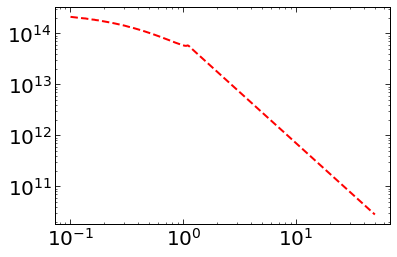

In [757]:
plt.loglog()
plt.plot(R_perp,dSigma_ccl[10],color='k',lw=3)
plt.plot(R_perp,dSigma[10],'--',color='r',lw=2)

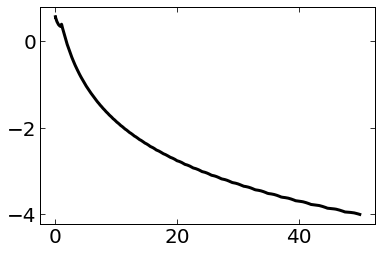

In [370]:
plt.plot(R_perp,(dSigma[10]-dSigma_ccl[10])/dSigma[10],color='k',lw=3)

I cannot use $\Delta \Sigma_{\rm NFW}$ from Hankl Transformation!

## 2nd Halo Term

In [140]:
help(ccl.correlation_3d)

Help on function correlation_3d in module pyccl.correlations:

correlation_3d(cosmo, a, r, p_of_k_a=None)
    Compute the 3D correlation function.
    
    Args:
        cosmo (:class:`~pyccl.core.Cosmology`): A Cosmology object.
        a (float): scale factor.
        r (float or array_like): distance(s) at which to calculate the 3D
                                 correlation function (in Mpc).
        p_of_k_a (:class:`~pyccl.pk2d.Pk2D`, `str` or None): 3D Power spectrum
            to integrate. If a string, it must correspond to one of the
            non-linear power spectra stored in `cosmo` (e.g.
            `'delta_matter:delta_matter'`). If `None`, the non-linear matter
            power spectrum stored in `cosmo` will be used.
    
    Returns:
        Value(s) of the correlation function at the input distance(s).



In [141]:
scale_factor_vec = 1/(1+z[::-1])
# make ccl power-spectrum object
pk2d = ccl.Pk2D(a_arr=scale_factor_vec, lk_arr=np.log(k_h), pk_arr=P_k, is_logp=False)

In [142]:
help(ccl.correlation_3d)

Help on function correlation_3d in module pyccl.correlations:

correlation_3d(cosmo, a, r, p_of_k_a=None)
    Compute the 3D correlation function.
    
    Args:
        cosmo (:class:`~pyccl.core.Cosmology`): A Cosmology object.
        a (float): scale factor.
        r (float or array_like): distance(s) at which to calculate the 3D
                                 correlation function (in Mpc).
        p_of_k_a (:class:`~pyccl.pk2d.Pk2D`, `str` or None): 3D Power spectrum
            to integrate. If a string, it must correspond to one of the
            non-linear power spectra stored in `cosmo` (e.g.
            `'delta_matter:delta_matter'`). If `None`, the non-linear matter
            power spectrum stored in `cosmo` will be used.
    
    Returns:
        Value(s) of the correlation function at the input distance(s).



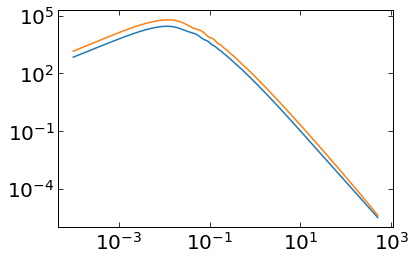

In [143]:
lpk_array = np.array([ccl.linear_matter_power(cosmoc,k_h,a) for a in scale_factor_vec])

plt.loglog(k_h,lpk_array[0])
plt.loglog(k_h, P_k[0])

In [144]:
xi_3d = np.array([ccl.correlation_3d(cosmoc, aval, R_perp, p_of_k_a=pk2d) for aval in scale_factor_vec])

In [145]:
from hankl import P2xi

def compute_hankel_xi(r,k,pk,l=0):
    si, _res = hankl.P2xi(k, pk, l=l)
    res = interp1d(si, _res.real)(r)
    return res
    
xi_hankl = np.array([compute_hankel_xi(R_perp,k_h,P_k_val,l=0) for P_k_val in P_k])

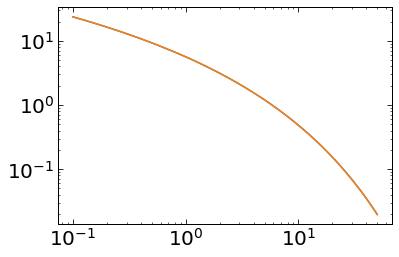

In [146]:
plt.loglog()
plt.plot(R_perp,xi_3d[0])
plt.plot(R_perp,xi_hankl[0])

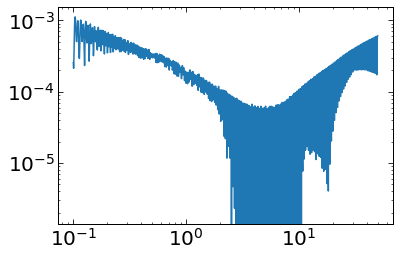

In [147]:
plt.loglog()
plt.plot(R_perp, np.log10(xi_hankl[0]/xi_3d[0]))

Very nice agreement on $\xi$ or $\rho$

In [148]:
sigma_hankl = np.array([compute_hankel(R_perp,k_h,P_k_val,mu=2) for P_k_val in P_k])

https://bdiemer.bitbucket.io/colossus/_static/tutorial_halo_profile.html#General-spline-profiles

```
# Create a spline profile from the radius array
print('Initializing spline profile from %d radial bins.' % (len(r)))
p_spline = profile_spline.SplineProfile(r, rho = rho)

# Now create a much finer array of radii and test how well the spline does
r = 10**np.arange(-2.0, 1.0, 0.01) * Rvir
rho_m = cosmo.rho_m(z)
rho_nfw = p_nfw.density(r)
rho_spline = p_spline.density(r)
```


In [232]:
from scipy.interpolate import interp1d
from colossus.halo import profile_spline
ix=30
rho_3d = (1+xi_3d)*rho_m
R_perp2 = np.logspace(np.log10(np.min(R_perp)+0.01),np.log10(np.max(R_perp)-0.01),300)
rho_3di = interp1d(R_perp, rho_3d[ix])(R_perp2)
p_spline = profile_spline.SplineProfile(R_perp2, rho = rho_3di)

/global/homes/j/jesteves/.conda/envs/clevarenv/lib/python3.9/site-packages/colossus/halo/profile_spline.py:146: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  logM[i], _ = scipy.integrate.quad(integrand_spline, 0.0, r[i])
/global/homes/j/jesteves/.conda/envs/clevarenv/lib/python3.9/site-packages/colossus/halo/profile_spline.py:148: RuntimeWarning: invalid value encountered in log
  logM = np.log(logM)


In [233]:
r_new = np.logspace(-1.1,np.log10(4.9),20)
dS = p_spline.deltaSigma(r_new)

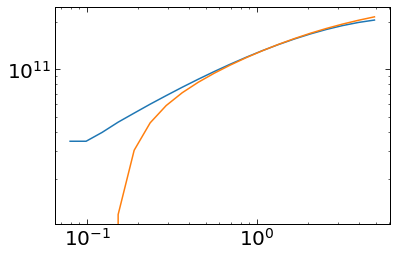

In [234]:
s_new =  np.interp(r_new, R_perp, sigma_hankl[ix]*rhom)
plt.loglog(r_new, s_new)
plt.loglog(r_new, dS)

/tmp/ipykernel_16308/2967233377.py:2: RuntimeWarning: invalid value encountered in log10
  plt.plot(r_new, np.log10(s_new/dS))


(-0.05, 0.05)

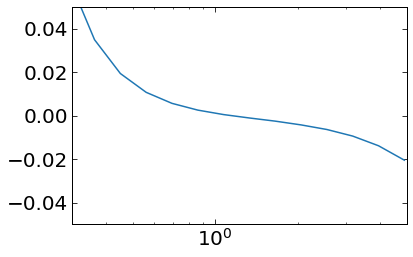

In [235]:
# plt.loglog()
plt.plot(r_new, np.log10(s_new/dS))
plt.xscale('log')
plt.xlim(0.3, 5.)
plt.ylim(-0.05,0.05)

On the limit range between $0.3 Mpc < r < 5. Mpc $ the hankl transformation agrees within 5\% with colossus.

# Analytical NFW Surface Mass Density $\Delta \Sigma$

Following Wright & Brainerd 2000, the shear profile is:
$$
\gamma_{\mathrm{NFW}}(x)= \begin{cases}\frac{r_s \delta_c \rho_c}{\Sigma_c} g_{<}(x) & x<1 \\ \frac{r_s \delta_c \rho_c}{\Sigma_c}\left[\frac{10}{3}+4 \ln \left(\frac{1}{2}\right)\right] & x=1 \\ \frac{r_s \delta_c \rho_c}{\Sigma_c} g_{>}(x) & x>1,\end{cases}
$$

We can find $\Delta \Sigma$ simply by multplying $\Sigma_{crit}$. And the unit functions are:
$$
\begin{aligned}
g_{<}(x)= & \frac{8 \operatorname{arctanh} \sqrt{(1-x) /(1+x)}}{x^2 \sqrt{1-x^2}}+\frac{4}{x^2} \ln \left(\frac{x}{2}\right) \\
& -\frac{2}{\left(x^2-1\right)}+\frac{4 \operatorname{arctanh} \sqrt{(1-x) /(1+x)}}{\left(x^2-1\right)\left(1-x^2\right)^{1 / 2}}, \\
g_{>}(x)= & \frac{8 \arctan \sqrt{(x-1) /(1+x)}}{x^2 \sqrt{x^2-1}}+\frac{4}{x^2} \ln \left(\frac{x}{2}\right) \\
& -\frac{2}{\left(x^2-1\right)}+\frac{4 \arctan \sqrt{(x-1) /(1+x)}}{\left(x^2-1\right)^{3 / 2}} .
\end{aligned}
$$

Note that the normalization factor $\delta_C$ is
$$
\delta_c=\frac{200}{3} \frac{c^3}{\ln (1+c)-c /(1+c)}
$$

In [ ]:
def g_less_than(x,core=0.001):
    term1 = 8.0*np.arctanh(np.sqrt((1.0-x)/(1.0+x)))*(inv_x2/np.sqrt(1.0-x**2))
    term2 = 4.0*( np.log(x/2.0 + eps) / (x**2+np.log(eps))
    term3 = -2.0/(x**2-1.0)
    term4 = 4.0*np.arctanh(np.sqrt((1.0-x)/(1.0+x)))/((x**2-1.0)*np.sqrt(1.0-x**2))
    res = term1 + term2 + term3 + term4
    return np.where(x<eps, 1., res)

def g_greater_than(x, eps=1e-9):
    x = x+eps
    term1 = 8.0*np.arctan(np.sqrt((x-1.0)/(1.0+x)))/(x**2*np.sqrt(x**2-1.0))
    term2 = 4.0/x**2 * np.log(x/2.0)
    term3 = -2.0/(x**2-1.0)
    term4 = 4.0*np.arctan(np.sqrt((x-1.0)/(1.0+x)))/((x**2-1.0)**(3.0/2.0))
    return term1 + term2 + term3 + term4

def g_nfw(x, eps=1e-9):
    """gNFW Eqn 15 and 16 Wright & Brained 2000

    Analytical normalized shear/deltaSigma profile

    Args:
        x (array): Rp/Rs where Rs is the scale radius, Rs = R200/c
    """
    res = np.zeros_like(x)
    ix = np.where(np.abs(x-1) <= eps)[0]
    res[ix] = 10./3. + 4*np.log(1/2.) 
    
    ix = np.where(x <= 1-eps)[0]
    res[ix] = g_less_than(x[ix])
    
    ix = np.where(x>=1+eps)[0]
    res[ix] = g_greater_than(x[ix])
    
    return res

def convert_m200_to_r200(m200,rho,odelta=200):
    rv = np.power(m200*3.0/(4.0*np.pi*rho*odelta),1.0/3.0)
    return rv

def deltaSigmaNFW_Analytical(radii, m200, c, z_eff=0.4):
    """Analytical NFW Surface Mass Density  (Eqn 14, Wright & Brained 2000)

    Args:
        radii (array): projected radii
        m200 (array): M200 critical mass in solar masses unit
        z_eff (float): effective redshift to concentration and critical density values
    """
    #c = duffy_concentration_relation(m200, z_eff=z_eff)
    rho_cz = rho_c*(omega_m*(1+z_eff)**3+(1-omega_m))
    r_virial = convert_m200_to_r200(m200, rho_cz)
    rs = r_virial/c

    # eqn 3 
    deltac = (200/3) * c**3/(np.log(1+c)-c/(1+c))
    gx  = g_nfw(radii/rs)
    return rs*deltac*rho_cz*gx


In [ ]:
radii = np.logspace(-1,1.1,100)
plt.loglog()
plt.plot(radii, g_nfw(radii))

In [ ]:
g_less_than(1e-9)

In [1236]:
concvec = duffy_concentration_relation(massvec, z_eff=0.4)
mm, rr = np.meshgrid(massvec, R_perp2, indexing='ij')
ds = deltaSigmaNFW_Analytical(rr, mm, concvec[:,np.newaxis], z_eff=0.)

/tmp/ipykernel_16308/1965437800.py:3: RuntimeWarning: invalid value encountered in sqrt
  term1 = 8.0*np.arctanh(np.sqrt((1.0-x)/(1.0+x)))*(inv_x2/np.sqrt(1.0-x**2))
/tmp/ipykernel_16308/1965437800.py:6: RuntimeWarning: invalid value encountered in sqrt
  term4 = 4.0*np.arctanh(np.sqrt((1.0-x)/(1.0+x)))/((x**2-1.0)*np.sqrt(1.0-x**2))
/tmp/ipykernel_16308/1965437800.py:12: RuntimeWarning: invalid value encountered in sqrt
  term1 = 8.0*np.arctan(np.sqrt((x-1.0)/(1.0+x)))/(x**2*np.sqrt(x**2-1.0))
/tmp/ipykernel_16308/1965437800.py:15: RuntimeWarning: invalid value encountered in sqrt
  term4 = 4.0*np.arctan(np.sqrt((x-1.0)/(1.0+x)))/((x**2-1.0)**(3.0/2.0))
/tmp/ipykernel_16308/1965437800.py:15: RuntimeWarning: invalid value encountered in power
  term4 = 4.0*np.arctan(np.sqrt((x-1.0)/(1.0+x)))/((x**2-1.0)**(3.0/2.0))


In [1237]:
# ds[0]

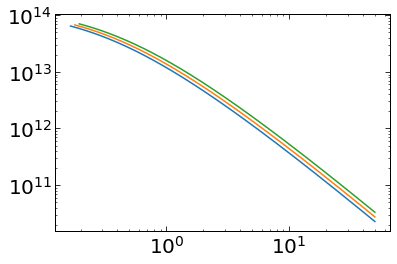

In [1238]:
plt.loglog()
plt.plot(R_perp2, ds[0])
plt.plot(R_perp2, ds[1])
plt.plot(R_perp2, ds[2])

In [1142]:
def NFW_Analytical(radii, m200, c, z_eff=0.4):
    """Analytical NFW Surface Mass Density  (Eqn 14, Wright & Brained 2000)

    Args:
        radii (array): projected radii
        m200 (array): M200 critical mass in solar masses unit
        z_eff (float): effective redshift to concentration and critical density values
    """
    # c = duffy_concentration_relation(m200, z_eff=z_eff)
    rho_cz = rho_c*(omega_m*(1+z_eff)**3+(1-omega_m))
    
    r_virial = convert_m200_to_r200(m200, rho_cz)
    rs = r_virial/c

    # eqn 3 
    deltac = (200/3) * c**3/(np.log(1+c)-c/(1+c))
    gx  = f_nfw(radii/rs)
    return rs*deltac*rho_cz*gx

def f_nfw(x, eps=1e-9):
    """fNFW Eqn 11 Wright & Brained 2000

    Analytical normalized shear/deltaSigma profile

    Args:
        x (array): Rp/Rs where Rs is the scale radius, Rs = R200/c
    """
    res = np.zeros_like(x)
    one = np.abs(x-1) <= eps
    res[~one] = np.where(x[~one]<1., f_less_than(x[~one]), f_greater_than(x[~one]))
    res[one]  = 2/3
    return res
    
def f_less_than(x):
    term1 = 2.0 / (x**2 - 1.0)
    term2 = 2.0 / np.sqrt(1.0 - x**2) * np.arctanh(np.sqrt((1.0 - x) / (1.0 + x)))
    return term1 * (1.0 - term2)
        
def f_greater_than(x):
    term1 = 2.0 / (x**2 - 1.0)
    term2 = 2.0 / np.sqrt(x**2 - 1.0) * np.arctan(np.sqrt((x - 1.0) / (1.0 + x)))
    return term1 * (1.0 - term2)

/tmp/ipykernel_16308/408092511.py:36: RuntimeWarning: invalid value encountered in sqrt
  term2 = 2.0 / np.sqrt(1.0 - x**2) * np.arctanh(np.sqrt((1.0 - x) / (1.0 + x)))
/tmp/ipykernel_16308/408092511.py:41: RuntimeWarning: invalid value encountered in sqrt
  term2 = 2.0 / np.sqrt(x**2 - 1.0) * np.arctan(np.sqrt((x - 1.0) / (1.0 + x)))


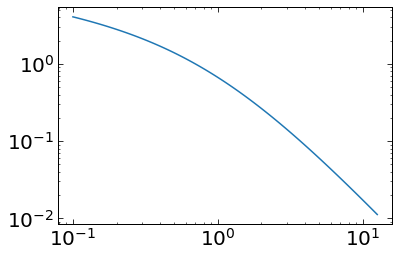

In [1143]:
plt.loglog()
plt.plot(radii, f_nfw(radii))

In [758]:
from colossus.halo import profile_nfw

def frac_error(x,y):
    return 1-(y/x)

def print_stats(x,y):
    fracE = frac_error(x,y)
    print('Std: %.5f'%(10**np.std(fracE)-1))
    print('Bias: %.5f'%(np.mean(fracE)))
          
def compare_nfw(radii, mass, z=0.0):
    h0 = cosmocol.h
    #c200c = duffy_concentration_relation(mass, z_eff=z)
    c200c = cM.get_concentration(cosmoc, mass, 1/(1+z), mdef_other=ccl.halos.MassDefVir())
    snew = NFW_Analytical(radii, mass, c200c, z_eff=z)
    
    conc = ccl.halos.ConcentrationConstant(c200c,mdef=ccl.halos.MassDefVir())
    nfw = ccl.halos.HaloProfileNFW(conc, truncated=False)
    sccl = nfw.projected(cosmoc, radii, mass, 1/(1+z), ccl.halos.MassDefVir())
    scol = profile_nfw.NFWProfile(M = mass, c = c200c, z = z, mdef = 'vir').surfaceDensity(1000*radii)*(1e3**2)
    
    print_stats(sccl,snew)
    print_stats(scol,snew)
    return snew, sccl, scol
    

In [759]:
radii = np.logspace(-1., 0.35, 20)
a,b,c = compare_nfw(radii, massvec[0], z=0.4)

Std: 0.22373
Bias: -0.13892
Std: 0.05839
Bias: 0.03972


/tmp/ipykernel_16308/408092511.py:36: RuntimeWarning: invalid value encountered in sqrt
  term2 = 2.0 / np.sqrt(1.0 - x**2) * np.arctanh(np.sqrt((1.0 - x) / (1.0 + x)))
/tmp/ipykernel_16308/408092511.py:41: RuntimeWarning: invalid value encountered in sqrt
  term2 = 2.0 / np.sqrt(x**2 - 1.0) * np.arctan(np.sqrt((x - 1.0) / (1.0 + x)))


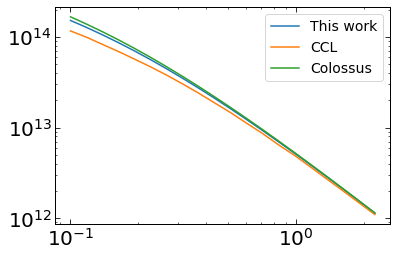

In [760]:
plt.loglog()
plt.plot(radii, a, label='This work')
plt.plot(radii, b, label='CCL')
plt.plot(radii, c, label='Colossus')
plt.legend(fontsize=14)

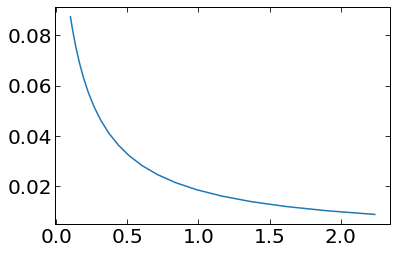

In [761]:
# plt.plot(radii, frac_error(b,a))
plt.plot(radii, frac_error(c,a))

# plt.plot(radii, b)
# plt.plot(radii, c)

In [762]:
def duffy_concentration_relation(m_h, z_eff=0.4, h0=0.7):
    zp_eff = (1+z_eff)
    m_h_pivot = 2e12/h0
    return 5.71*np.power(m_h/m_h_pivot,-0.084)*np.power(zp_eff,-0.47)

In [1081]:
import cluster_toolkit

def compare_deltaSigma(radii, mass, z=0.0):
    h0 = cosmocol.h
    #c200c = duffy_concentration_relation(mass, z_eff=z)
    c200c = cM.get_concentration(cosmoc, mass*h0, 1/(1+z), mdef_other=ccl.halos.MassDef200c())
    snew = deltaSigmaNFW_Analytical(radii*h0, mass*h0, c200c, z_eff=z)
    
    conc = ccl.halos.ConcentrationConstant(c200c,mdef=ccl.halos.MassDef200c())
    nfw = ccl.halos.HaloProfileNFW(conc, truncated=False)
    sccl = nfw.cumul2d(cosmoc, radii*h0, mass*h0, 1/(1+z), ccl.halos.MassDef200c())-nfw.projected(cosmoc, radii*h0, mass*h0, 1/(1+z), ccl.halos.MassDef200c())
    _scol = cluster_toolkit.deltasigma.Sigma_nfw_at_R(radii, mass, c200c, omega_m, delta=200)#*(1e6**2)
    scol = cluster_toolkit.deltasigma.DeltaSigma_at_R(radii, radii, _scol, mass, c200c, omega_m, delta=200)*(1e6**2)
    #scol = profile_nfw.NFWProfile(M = mass, c = c200c, z = z, mdef = 'vir').deltaSigma(1000*radii)*(1e3**2)
    
    print_stats(sccl,snew)
    print_stats(scol,snew)
    return snew, sccl, scol
    

In [1082]:
radii = np.logspace(-1., 0.35, 20)
a,b,c = compare_deltaSigma(radii, massvec[0], z=0.0)

Std: 0.04622
Bias: -0.00071
Std: 0.08025
Bias: -0.32389


/tmp/ipykernel_16308/3404182409.py:2: RuntimeWarning: invalid value encountered in sqrt
  term1 = 8.0*np.arctanh(np.sqrt((1.0-x)/(1.0+x)))/(x**2*np.sqrt(1.0-x**2))
/tmp/ipykernel_16308/3404182409.py:5: RuntimeWarning: invalid value encountered in sqrt
  term4 = 4.0*np.arctanh(np.sqrt((1.0-x)/(1.0+x)))/((x**2-1.0)*np.sqrt(1.0-x**2))
/tmp/ipykernel_16308/3404182409.py:9: RuntimeWarning: invalid value encountered in sqrt
  term1 = 8.0*np.arctan(np.sqrt((x-1.0)/(1.0+x)))/(x**2*np.sqrt(x**2-1.0))
/tmp/ipykernel_16308/3404182409.py:12: RuntimeWarning: invalid value encountered in sqrt
  term4 = 4.0*np.arctan(np.sqrt((x-1.0)/(1.0+x)))/((x**2-1.0)**(3.0/2.0))
/tmp/ipykernel_16308/3404182409.py:12: RuntimeWarning: invalid value encountered in power
  term4 = 4.0*np.arctan(np.sqrt((x-1.0)/(1.0+x)))/((x**2-1.0)**(3.0/2.0))


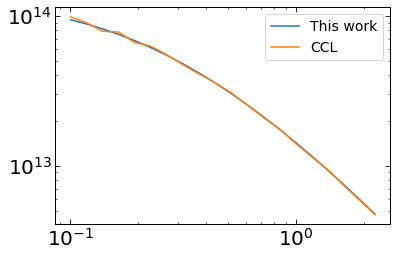

In [1090]:
plt.loglog()
plt.plot(radii, a, label='This work')
plt.plot(radii, b, label='CCL')
# plt.plot(radii, c/0.7, label='Cluster Tool Kit')
plt.legend(fontsize=14)

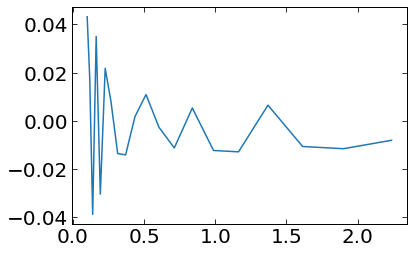

In [1094]:
plt.plot(radii, frac_error(b,a))
# plt.plot(radii, frac_error(c/0.7,a))

# plt.plot(radii, b)
# plt.plot(radii, c)

In [1093]:
# zvec = np.linspace(0,1.,21)
# plt.plot(zvec, rho_c*(omega_m*(1+zvec)**3+(1-omega_m)))
# plt.plot(zvec, cosmocol.rho_c(zvec)*1e9*cosmocol.h**2)

In [1009]:
# help(cosmocol.rho_c)

In [1010]:
# help(cM)

In [770]:
# help(cosmoc)

In [771]:
help(cM.get_concentration)

Help on method get_concentration in module pyccl.halos.concentration:

get_concentration(cosmo, M, a, mdef_other=None) method of pyccl.halos.concentration.ConcentrationDuffy08 instance
    Returns the concentration for input parameters.
    
    Args:
        cosmo (:class:`~pyccl.core.Cosmology`): A Cosmology object.
        M (float or array_like): halo mass in units of M_sun.
        a (float): scale factor.
        mdef_other (:class:`~pyccl.halos.massdef.MassDef`):
            the mass definition object that defines M.
    
    Returns:
        float or array_like: concentration.

